# Workshop 5: Deterministic Analysis (notebook 2 of 2)



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import openturns as ot
ot.Log.Show(ot.Log.NONE)

import Probabilistic

## Task 1: Set up deterministic calculation

Everything needed to describe stress in the tunnels is included in the `*.py` files that are imported below. See notebook `Analysis_deterministic.ipynb` for additional information.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 1:</b>
confirm that the Python modules can be imported successfully.
</p>
</div>

Height of the beam: 2.38e+01 m
Width of the beam: 9.20e+00 m
Area of the beam: 3.80e+01 m2
E-modulus of the beam: 5.00e+10 Pa
Torsion constant of the beam: 5.07e+04 m4
Shear modulus of the beam: 1.92e+10 Pa
Density of the beam: 2.50e+03 kg/m3

Mass per unit length of the beam: 1.50e+05 kg/m
Bending stiffness of the beam, x-direction : 4.87e+15 N.m2
Bending stiffness of the beam, z-direction: 7.28e+14 N.m2
Axial stiffness of the beam: 1.90e+12 N
Torsional stiffness of the beam: 9.74e+14 N.m2
Moment of inertia of the beam: 1.27e+08 m2

Number of tunnel elements: 521.0
Deviation of tunnel alignment from straight line, in:
  X: 17007.4 m
  Y: 2003.68 m
  Z: 0 m


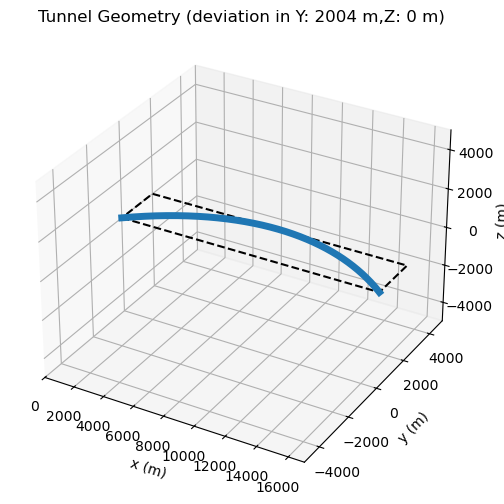

In [2]:
import FEM
import Morrisson_forces

## Task 2: Determine statistical properties of Random Variables


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1:</b>
define the marginal distributions using OpenTURNs (the tuple containing the random variables and their descriptions is already provided).
</p>
</div>

In [3]:
# YOUR_CODE_HERE

# Solution:
X1 = ot.Exponential(2.0309)
X2 = ot.Exponential(2.0663)
X3 = ot.Normal(2, 0.2)

X = (X1, X2, X3)
descriptions = ["windsea","swell", "u_current"]

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2:</b>
visualize each of the random variables to confirm that they are implemented correctly, and that you get a sense for their magnitude and distribution.
</p>
</div>

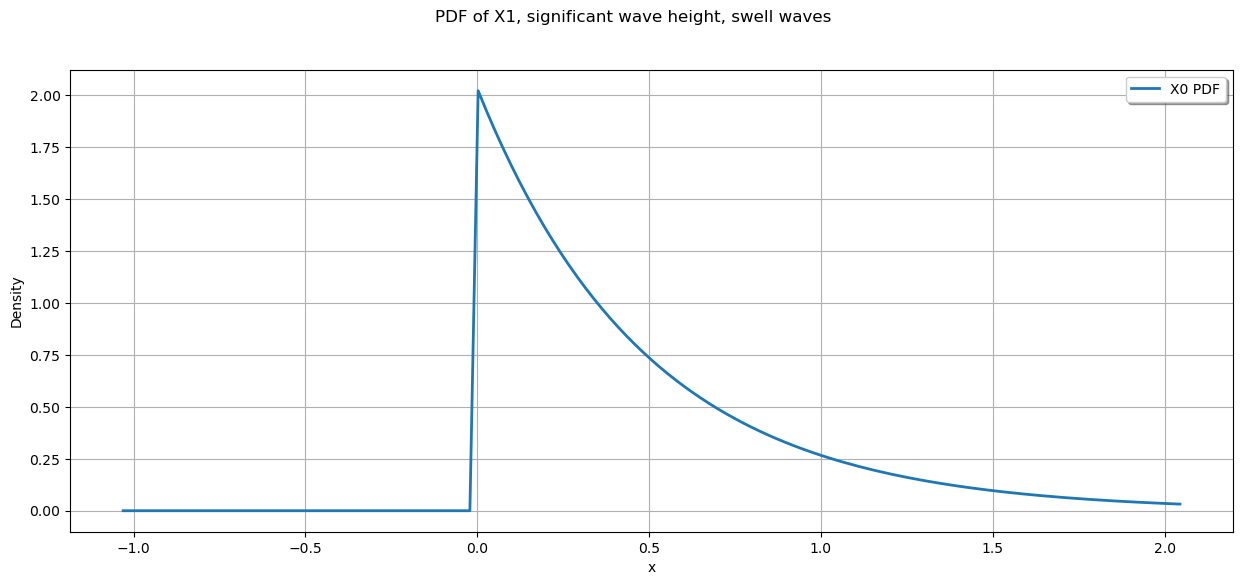

In [4]:
X1_pdf = X1.drawPDF()
graph = X1.drawPDF()
graph.setTitle("PDF of X1, significant wave height, swell waves")
graph.setXTitle("x")
graph.setYTitle("Density")
view = ot.viewer.View(graph)
plt.show()

## Task 3: Determine the Limit State Function

To keep things easy to follow, we will divide this into two parts:
1. write a function to calculate the total axial: `total_calculation_axial_stresses`
2. write a function to represent the vectorized LSF, as in WS04: `myLSF`

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 3.1:</b>
complete the function as done in notebook <code>Analysis_deterministic.ipynb</code> to evaluate the axial stress.
</p>
</div>

In [5]:
# def total_calculation_axial_stresses(significant_wave_height_swell,
#                                      significant_wave_height_windsea,
#                                      U_current_velocity):
#     '''Find axial stresses due to wind and swell waves.
    
#     Inputs: three load random variables
#     Returns: stress
#     '''
    
#     YOUR_CODE_FROM_DETERMINISTIC_NOTEBOOK_HERE
#     # Note: you do not need to include the `time` tracking here.

# SOLUTION:
def total_calculation_axial_stresses(significant_wave_height_swell,
                                     significant_wave_height_windsea,
                                     U_current_velocity):
    '''Find axial stresses due to wind and swell waves.
    
    Inputs: three load random variables
    Returns: stress
    '''
    sigma_wind = FEM.calculate_axial_stress_FEM(
        Morrisson_forces.F_morison_wind(
            significant_wave_height_windsea))
    
    sigma_swell_and_current = FEM.calculate_axial_stress_FEM(
        Morrisson_forces.F_morison_swell_current(
            significant_wave_height_swell,
            U_current_velocity))
    
    # Total stress
    sigma = sigma_wind + sigma_swell_and_current 
    
    return sigma 

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 3.2:</b>
based on the definition of failure provided above, and your understanding of the stress calculation algorithm (notebook <code>Analysis_deterministic.ipynb</code>), definte the limit-state function. Remember to vectorize the function.
</p>
</div>

In [6]:
# def myLSF(x):
#     ''' 
#     Vectorized limit-state function.

#     Inputs: x (array of random variables)
#     Output: limit-state function value
#     '''
#     YOUR_CODE_HERE

# Solution:
def myLSF(x):
    ''' 
    Vectorized limit-state function.

    Inputs: x (array of random variables)
    Output: limit-state function value
    '''
    sigma_max = 75 # MPa, maximum allowable compression stress in special concrete
    g = [sigma_max - np.max(total_calculation_axial_stresses(x[0], x[1], x[2]))]

    return g

In [7]:
print(myLSF([1, 1,.1, 75]))

[np.float64(-33.90126795752556)]


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 3.3:</b>
we need to define failure for OpenTURNs. Use the cell below to define the failure criteria for use in OpenTURN's.
<br><br>
<em>Hint: look at the inputs for function <code>input_OpenTurns</code>, which is defined inside the file <code>Probabilistic.py</code>. Executing the code cell below will print out the docstring.</em>
</p>
</div>

In [8]:
help(Probabilistic.input_OpenTurns)
# YOUR_CODE_HERE

# Solution:
failure_threshold = 0

Help on function input_OpenTurns in module Probabilistic:

input_OpenTurns(X, descriptions, myLSF, failure_threshold)
    Set up OpenTURNs objects for MCS and FORM analysis.

    Inputs:
    X (list of ot.Distribution): List of distributions for each input variable.
    descriptions (list of str): List of descriptions for each input variable.
    myLSF (function): Limit state function.
    failure_threshold (float): Threshold for failure.

    Returns:
    None (sets global variables for OpenTURNs objects).



## Task 4: Run Monte Carlo Simulation and FORM analysis

Most of the work has been done for you inside the file `Probabilistic.py`. It reuses the same code for using OpenTURNs that you saw previously in WS03 and WS04.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 4.1:</b>
read through the functions in <code>Probabilistic.py</code> until you understand what each one does and how you can use it to solve the component reliability problem. Test your understanding by taking turns explaining the contents to your fellow group members.
</p>
</div>

You now have everything you need to complete the component reliability problem. All you have to do is execute the right code, interpret the results, then write about it in `Report.md`.

Note that you will have to decide yourself how to use each method (e.g., FORM versus MCS). Note that the FEM model takes some time to run, so using a lot of simulations with MCS is probably not a good way to start.

Before you start running code, take a few minutes to review the following overview pages in the workbook:
- [Overview of FORM](https://teachbooks.github.io/HOS-workbook/2024/component/form.html)
- [Comparison of MCS and FORM](https://teachbooks.github.io/HOS-workbook/2024/component/mcs_form.html)



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 4.2:</b>
<br>Use the functions in <code>Probabilistic.py</code> to complete the MCS and FORM analysis. Because our target probability is 1%, we should run MCS for <em>at least</em> 1000 simulations. Think carefully about how long that analysis might take before you start it (for example, how long did each analysis take in the deterministic notebook?). Perhaps it is better to start with a different (faster) method?

Note that the task of setting up the reliability analysis will be <em>much</em> easier if you actually spent some time on Task 4.1 &#128540;<br><br>
<em>You are free to modify the code in <code>Probabilistic.py</code>, but it is not required in order to complete the assignment.</em>
</p>
</div>

In [9]:
print(X)
print(descriptions, myLSF, failure_threshold)

(class=Exponential name=Exponential dimension=1 lambda=2.0309 gamma=0, class=Exponential name=Exponential dimension=1 lambda=2.0663 gamma=0, class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[2] sigma=class=Point name=Unnamed dimension=1 values=[0.2] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1])
['windsea', 'swell', 'u_current'] <function myLSF at 0x000001F6983E5300> 0


In [10]:
# YOUR_CODE_HERE

# Solution:
Probabilistic.input_OpenTurns(X, descriptions, myLSF, failure_threshold)
result, x_star, u_star, pf_FORM, beta = Probabilistic.run_FORM_analysis()
alpha_ot, alpha, sens = Probabilistic.importance_factors(result)

# for illustration purposes. don't do this because it will take 20-30 minutes!
# pf_mc = Probabilistic.run_MonteCarloSimulation(mc_size=1000)

The FORM analysis took 107.314 seconds
FORM result, pf = 0.1845
FORM result, beta = 0.898

The design point in the u space:  [0.59463,0.672736,0.0294587]
The design point in the x space:  [0.633803,0.669828,2.00589]
--- FORM Importance Factors (alpha) ---


Importance factors, from OpenTURNs:
   0.438
   0.561
   0.001

Importance factors, based on normal vector in U-space = 
   0.662
   0.749
   0.033
Note: this will be different from result.getImportanceFactors()
if there are resistance variables.

Sensitivity of Reliability Index to Multivariate Distribution

Distribution item number: 0
  Item name: windsea

Distribution item number: 1
  Item name: swell

Distribution item number: 2
  Item name: u_current

Distribution item number: 3
  Item name: NormalCopula
    +0.000e+00 for parameter R_2_1_copula
    +0.000e+00 for parameter R_3_1_copula
    +0.000e+00 for parameter R_3_2_copula


## Task 5: Design Case

The consortium of Colomes & Agarwal Inc. and Frank & Co is still trying to decide what material to use for the tunnel: concrete or steel. They think the current concrete design is insufficient, so they have asked you to look into the matter for them. There are two options:
1. Improve the quality of the concrete production process, which reduces $\sigma$ from 5 to 1
2. Change the material to steel (distribution defined in `README.md`)

It is not immediately clear which will have a bigger impact, as the standard deviation is much higher for steel, despite the higher mean value.


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:3px 20px; color: black; border-radius: 10px; width: 95%">
<p>
<b>Task 5:</b> add a fourth variable to the reliability analysis and run a few more reliability calculations. Note that you will need to modify several Python objects:the create a new random varable <code>X4</code>, redefine the vector of random variables <code>X</code>, redefine the <code>descriptions</code> and create a new limit-state function.
</p>
</div>

In [12]:

# Solution:
X4 = ot.Normal(75, 5)
X4 = ot.Normal(75, 1)
X4 = ot.Normal(250, 20)

X = (X1, X2, X3, X4)
descriptions = ["windsea","swell", "u_current", "sigma_max"]

def myLSF2(x):
    ''' 
    Vectorized limit-state function.

    Inputs: x (array of random variables)
    Output: limit-state function value
    '''
    sigma_max = x[3] # MPa, maximum allowable compression stress in special concrete
    g = [sigma_max - np.max(total_calculation_axial_stresses(x[0], x[1], x[2]))]

    return g

Probabilistic.input_OpenTurns(X, descriptions, myLSF2, failure_threshold)
result, x_star, u_star, pf_FORM, beta = Probabilistic.run_FORM_analysis()
alpha_ot, alpha, sens = Probabilistic.importance_factors(result)

# for illustration purposes. don't do this because it will take 20-30 minutes!
# pf_mc = Probabilistic.run_MonteCarloSimulation(mc_size=1000)

The FORM analysis took 401.887 seconds
FORM result, pf = 0.0006
FORM result, beta = 3.259

The design point in the u space:  [2.30727,2.20684,0.0191026,-0.654778]
The design point in the x space:  [2.24259,2.07767,2.00382,236.904]
--- FORM Importance Factors (alpha) ---


Importance factors, from OpenTURNs:
   0.501
   0.458
   0.000
   0.040

Importance factors, based on normal vector in U-space = 
   0.708
   0.677
   0.006
  -0.201
Note: this will be different from result.getImportanceFactors()
if there are resistance variables.

Sensitivity of Reliability Index to Multivariate Distribution

Distribution item number: 0
  Item name: windsea

Distribution item number: 1
  Item name: swell

Distribution item number: 2
  Item name: u_current

Distribution item number: 3
  Item name: sigma_max

Distribution item number: 4
  Item name: NormalCopula
    +0.000e+00 for parameter R_2_1_copula
    +0.000e+00 for parameter R_3_1_copula
    +0.000e+00 for parameter R_3_2_copula
    +0.000e+00 f